<a href="https://colab.research.google.com/github/DishantB0411/fe-gan-VaR/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader

class VIXReturnDataset(Dataset):
    def __init__(self, filepath, window_size=250):
        df = pd.read_csv(filepath)
        self.returns = df['LogReturn'].values
        self.window_size = window_size
        self.samples = self.create_sequences()

    def create_sequences(self):
        X = []
        for i in range(len(self.returns) - self.window_size):
            X.append(self.returns[i:i + self.window_size])
        return np.array(X, dtype=np.float32)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [ ]:
df = pd.read_csv('vix_log_returns.csv')
df.head()

,Date,VIX,LogReturn
0,1990-01-03,18.190001,0.053640
1,1990-01-04,19.219999,0.055079
2,1990-01-05,20.110001,0.045266
3,1990-01-08,20.260000,0.007431
4,1990-01-09,22.200001,0.091444


In [ ]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, noise_dim=100, output_dim=250):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 1000),
            nn.ReLU(),
            *[nn.Sequential(nn.Linear(1000, 1000), nn.BatchNorm1d(1000), nn.ReLU()) for _ in range(8)],
            nn.Linear(1000, output_dim)
        )

    def forward(self, z):
        return self.model(z)


class Critic(nn.Module):
    def __init__(self, input_dim=250):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 100),
            nn.ReLU(),
            *[nn.Sequential(nn.Linear(100, 100), nn.ReLU()) for _ in range(3)],
            nn.Linear(100, 1)
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
# wgan_train.py

import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm

# Hyperparameters
noise_dim = 100
batch_size = 64
n_epochs = 100
n_critic = 5
clip_value = 0.01
lr = 5e-5
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load data
dataset = VIXReturnDataset("vix_log_returns.csv", window_size=250)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize models
G = Generator(noise_dim=noise_dim).to(device)
D = Critic().to(device)

# Optimizers
opt_G = optim.RMSprop(G.parameters(), lr=lr)
opt_D = optim.RMSprop(D.parameters(), lr=lr)

# Training
for epoch in range(n_epochs):
    for i, real in enumerate(tqdm(loader)):
        real = real.to(device)

        # Train Critic
        for _ in range(n_critic):
            z = torch.randn(real.size(0), noise_dim).to(device)
            fake = G(z).detach()
            loss_D = -torch.mean(D(real)) + torch.mean(D(fake))

            opt_D.zero_grad()
            loss_D.backward()
            opt_D.step()

            for p in D.parameters():
                p.data.clamp_(-clip_value, clip_value)

        # Train Generator
        z = torch.randn(real.size(0), noise_dim).to(device)
        fake = G(z)
        loss_G = -torch.mean(D(fake))

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

    print(f"Epoch {epoch + 1}/{n_epochs} | Loss D: {loss_D.item():.4f} | Loss G: {loss_G.item():.4f}")


100%|██████████| 134/134 [00:05<00:00, 25.12it/s]


Epoch 1/100 | Loss D: -0.0003 | Loss G: 0.0100


100%|██████████| 134/134 [00:04<00:00, 33.37it/s]


Epoch 2/100 | Loss D: -0.0002 | Loss G: 0.0089


100%|██████████| 134/134 [00:04<00:00, 32.52it/s]


Epoch 3/100 | Loss D: -0.0014 | Loss G: 0.0097


100%|██████████| 134/134 [00:06<00:00, 21.40it/s]


Epoch 4/100 | Loss D: -0.0001 | Loss G: 0.0088


100%|██████████| 134/134 [00:04<00:00, 30.44it/s]


Epoch 5/100 | Loss D: -0.0006 | Loss G: 0.0091


100%|██████████| 134/134 [00:04<00:00, 32.21it/s]


Epoch 6/100 | Loss D: -0.0004 | Loss G: 0.0091


100%|██████████| 134/134 [00:04<00:00, 32.36it/s]


Epoch 7/100 | Loss D: -0.0002 | Loss G: 0.0088


100%|██████████| 134/134 [00:03<00:00, 33.87it/s]


Epoch 8/100 | Loss D: -0.0001 | Loss G: 0.0088


100%|██████████| 134/134 [00:04<00:00, 29.54it/s]


Epoch 9/100 | Loss D: -0.0002 | Loss G: 0.0090


100%|██████████| 134/134 [00:04<00:00, 31.55it/s]


Epoch 10/100 | Loss D: -0.0001 | Loss G: 0.0088


100%|██████████| 134/134 [00:03<00:00, 34.75it/s]


Epoch 11/100 | Loss D: -0.0001 | Loss G: 0.0088


100%|██████████| 134/134 [00:04<00:00, 32.08it/s]


Epoch 12/100 | Loss D: -0.0001 | Loss G: 0.0089


100%|██████████| 134/134 [00:04<00:00, 32.92it/s]


Epoch 13/100 | Loss D: -0.0004 | Loss G: 0.0089


100%|██████████| 134/134 [00:03<00:00, 34.78it/s]


Epoch 14/100 | Loss D: -0.0002 | Loss G: 0.0090


100%|██████████| 134/134 [00:04<00:00, 31.08it/s]


Epoch 15/100 | Loss D: -0.0009 | Loss G: 0.0102


100%|██████████| 134/134 [00:04<00:00, 33.39it/s]


Epoch 16/100 | Loss D: -0.0001 | Loss G: 0.0090


100%|██████████| 134/134 [00:03<00:00, 34.21it/s]


Epoch 17/100 | Loss D: -0.0003 | Loss G: 0.0089


100%|██████████| 134/134 [00:04<00:00, 28.01it/s]


Epoch 18/100 | Loss D: -0.0001 | Loss G: 0.0088


100%|██████████| 134/134 [00:04<00:00, 31.17it/s]


Epoch 19/100 | Loss D: -0.0006 | Loss G: 0.0091


100%|██████████| 134/134 [00:03<00:00, 34.23it/s]


Epoch 20/100 | Loss D: -0.0008 | Loss G: 0.0094


100%|██████████| 134/134 [00:04<00:00, 30.46it/s]


Epoch 21/100 | Loss D: -0.0001 | Loss G: 0.0097


100%|██████████| 134/134 [00:03<00:00, 34.40it/s]


Epoch 22/100 | Loss D: -0.0001 | Loss G: 0.0089


100%|██████████| 134/134 [00:03<00:00, 34.74it/s]


Epoch 23/100 | Loss D: -0.0002 | Loss G: 0.0089


100%|██████████| 134/134 [00:04<00:00, 30.27it/s]


Epoch 24/100 | Loss D: -0.0003 | Loss G: 0.0089


100%|██████████| 134/134 [00:03<00:00, 34.20it/s]


Epoch 25/100 | Loss D: -0.0010 | Loss G: 0.0093


100%|██████████| 134/134 [00:03<00:00, 35.17it/s]


Epoch 26/100 | Loss D: -0.0001 | Loss G: 0.0088


100%|██████████| 134/134 [00:04<00:00, 30.52it/s]


Epoch 27/100 | Loss D: -0.0004 | Loss G: 0.0091


100%|██████████| 134/134 [00:03<00:00, 35.14it/s]


Epoch 28/100 | Loss D: -0.0003 | Loss G: 0.0090


100%|██████████| 134/134 [00:03<00:00, 35.68it/s]


Epoch 29/100 | Loss D: -0.0005 | Loss G: 0.0091


100%|██████████| 134/134 [00:04<00:00, 30.74it/s]


Epoch 30/100 | Loss D: -0.0004 | Loss G: 0.0088


100%|██████████| 134/134 [00:04<00:00, 27.54it/s]


Epoch 31/100 | Loss D: -0.0003 | Loss G: 0.0091


100%|██████████| 134/134 [00:04<00:00, 32.46it/s]


Epoch 32/100 | Loss D: -0.0002 | Loss G: 0.0088


100%|██████████| 134/134 [00:04<00:00, 30.54it/s]


Epoch 33/100 | Loss D: -0.0001 | Loss G: 0.0089


100%|██████████| 134/134 [00:03<00:00, 35.39it/s]


Epoch 34/100 | Loss D: -0.0003 | Loss G: 0.0091


100%|██████████| 134/134 [00:03<00:00, 35.12it/s]


Epoch 35/100 | Loss D: -0.0003 | Loss G: 0.0090


100%|██████████| 134/134 [00:04<00:00, 30.59it/s]


Epoch 36/100 | Loss D: -0.0004 | Loss G: 0.0089


100%|██████████| 134/134 [00:03<00:00, 34.13it/s]


Epoch 37/100 | Loss D: -0.0000 | Loss G: 0.0088


100%|██████████| 134/134 [00:03<00:00, 34.42it/s]


Epoch 38/100 | Loss D: -0.0005 | Loss G: 0.0092


100%|██████████| 134/134 [00:04<00:00, 29.58it/s]


Epoch 39/100 | Loss D: -0.0002 | Loss G: 0.0090


100%|██████████| 134/134 [00:03<00:00, 34.11it/s]


Epoch 40/100 | Loss D: -0.0001 | Loss G: 0.0087


100%|██████████| 134/134 [00:03<00:00, 34.87it/s]


Epoch 41/100 | Loss D: -0.0003 | Loss G: 0.0091


100%|██████████| 134/134 [00:04<00:00, 29.64it/s]


Epoch 42/100 | Loss D: -0.0008 | Loss G: 0.0100


100%|██████████| 134/134 [00:03<00:00, 34.68it/s]


Epoch 43/100 | Loss D: -0.0003 | Loss G: 0.0090


100%|██████████| 134/134 [00:03<00:00, 34.84it/s]


Epoch 44/100 | Loss D: -0.0004 | Loss G: 0.0092


100%|██████████| 134/134 [00:04<00:00, 28.75it/s]


Epoch 45/100 | Loss D: -0.0017 | Loss G: 0.0113


100%|██████████| 134/134 [00:04<00:00, 31.68it/s]


Epoch 46/100 | Loss D: -0.0031 | Loss G: 0.0112


100%|██████████| 134/134 [00:03<00:00, 34.75it/s]


Epoch 47/100 | Loss D: -0.0000 | Loss G: 0.0089


100%|██████████| 134/134 [00:04<00:00, 30.64it/s]


Epoch 48/100 | Loss D: -0.0002 | Loss G: 0.0089


100%|██████████| 134/134 [00:03<00:00, 34.70it/s]


Epoch 49/100 | Loss D: -0.0004 | Loss G: 0.0093


100%|██████████| 134/134 [00:03<00:00, 34.88it/s]


Epoch 50/100 | Loss D: -0.0001 | Loss G: 0.0090


100%|██████████| 134/134 [00:04<00:00, 29.61it/s]


Epoch 51/100 | Loss D: -0.0000 | Loss G: 0.0090


100%|██████████| 134/134 [00:03<00:00, 33.75it/s]


Epoch 52/100 | Loss D: -0.0004 | Loss G: 0.0091


100%|██████████| 134/134 [00:03<00:00, 34.00it/s]


Epoch 53/100 | Loss D: -0.0002 | Loss G: 0.0091


100%|██████████| 134/134 [00:04<00:00, 30.07it/s]


Epoch 54/100 | Loss D: -0.0002 | Loss G: 0.0095


100%|██████████| 134/134 [00:03<00:00, 34.28it/s]


Epoch 55/100 | Loss D: -0.0004 | Loss G: 0.0094


100%|██████████| 134/134 [00:03<00:00, 34.51it/s]


Epoch 56/100 | Loss D: -0.0008 | Loss G: 0.0103


100%|██████████| 134/134 [00:04<00:00, 30.80it/s]


Epoch 57/100 | Loss D: -0.0006 | Loss G: 0.0096


100%|██████████| 134/134 [00:03<00:00, 35.42it/s]


Epoch 58/100 | Loss D: -0.0004 | Loss G: 0.0092


100%|██████████| 134/134 [00:03<00:00, 34.49it/s]


Epoch 59/100 | Loss D: -0.0001 | Loss G: 0.0088


100%|██████████| 134/134 [00:04<00:00, 30.55it/s]


Epoch 60/100 | Loss D: -0.0001 | Loss G: 0.0089


100%|██████████| 134/134 [00:03<00:00, 34.51it/s]


Epoch 61/100 | Loss D: -0.0016 | Loss G: 0.0102


100%|██████████| 134/134 [00:03<00:00, 34.21it/s]


Epoch 62/100 | Loss D: -0.0005 | Loss G: 0.0097


100%|██████████| 134/134 [00:04<00:00, 30.20it/s]


Epoch 63/100 | Loss D: -0.0002 | Loss G: 0.0092


100%|██████████| 134/134 [00:03<00:00, 34.28it/s]


Epoch 64/100 | Loss D: -0.0039 | Loss G: 0.0136


100%|██████████| 134/134 [00:03<00:00, 34.70it/s]


Epoch 65/100 | Loss D: -0.0001 | Loss G: 0.0090


100%|██████████| 134/134 [00:04<00:00, 30.21it/s]


Epoch 66/100 | Loss D: -0.0009 | Loss G: 0.0094


100%|██████████| 134/134 [00:04<00:00, 33.24it/s]


Epoch 67/100 | Loss D: -0.0001 | Loss G: 0.0090


100%|██████████| 134/134 [00:04<00:00, 33.12it/s]


Epoch 68/100 | Loss D: -0.0004 | Loss G: 0.0098


100%|██████████| 134/134 [00:04<00:00, 29.49it/s]


Epoch 69/100 | Loss D: -0.0002 | Loss G: 0.0094


100%|██████████| 134/134 [00:04<00:00, 33.41it/s]


Epoch 70/100 | Loss D: -0.0004 | Loss G: 0.0098


100%|██████████| 134/134 [00:04<00:00, 31.14it/s]


Epoch 71/100 | Loss D: -0.0001 | Loss G: 0.0093


100%|██████████| 134/134 [00:04<00:00, 28.35it/s]


Epoch 72/100 | Loss D: -0.0001 | Loss G: 0.0093


100%|██████████| 134/134 [00:04<00:00, 32.01it/s]


Epoch 73/100 | Loss D: -0.0002 | Loss G: 0.0093


100%|██████████| 134/134 [00:04<00:00, 29.23it/s]


Epoch 74/100 | Loss D: -0.0002 | Loss G: 0.0099


100%|██████████| 134/134 [00:04<00:00, 32.21it/s]


Epoch 75/100 | Loss D: -0.0000 | Loss G: 0.0092


100%|██████████| 134/134 [00:03<00:00, 35.07it/s]


Epoch 76/100 | Loss D: -0.0002 | Loss G: 0.0093


100%|██████████| 134/134 [00:04<00:00, 33.09it/s]


Epoch 77/100 | Loss D: -0.0003 | Loss G: 0.0095


100%|██████████| 134/134 [00:04<00:00, 32.11it/s]


Epoch 78/100 | Loss D: -0.0002 | Loss G: 0.0095


100%|██████████| 134/134 [00:03<00:00, 34.94it/s]


Epoch 79/100 | Loss D: -0.0004 | Loss G: 0.0095


100%|██████████| 134/134 [00:04<00:00, 32.83it/s]


Epoch 80/100 | Loss D: -0.0001 | Loss G: 0.0090


100%|██████████| 134/134 [00:04<00:00, 31.56it/s]


Epoch 81/100 | Loss D: -0.0003 | Loss G: 0.0095


100%|██████████| 134/134 [00:03<00:00, 34.87it/s]


Epoch 82/100 | Loss D: -0.0004 | Loss G: 0.0095


100%|██████████| 134/134 [00:04<00:00, 32.58it/s]


Epoch 83/100 | Loss D: -0.0003 | Loss G: 0.0095


100%|██████████| 134/134 [00:04<00:00, 32.00it/s]


Epoch 84/100 | Loss D: -0.0001 | Loss G: 0.0096


100%|██████████| 134/134 [00:03<00:00, 34.97it/s]


Epoch 85/100 | Loss D: -0.0002 | Loss G: 0.0095


100%|██████████| 134/134 [00:04<00:00, 33.21it/s]


Epoch 86/100 | Loss D: -0.0001 | Loss G: 0.0093


100%|██████████| 134/134 [00:04<00:00, 31.66it/s]


Epoch 87/100 | Loss D: -0.0006 | Loss G: 0.0100


100%|██████████| 134/134 [00:03<00:00, 34.23it/s]


Epoch 88/100 | Loss D: -0.0002 | Loss G: 0.0090


100%|██████████| 134/134 [00:04<00:00, 32.62it/s]


Epoch 89/100 | Loss D: -0.0009 | Loss G: 0.0092


100%|██████████| 134/134 [00:04<00:00, 31.52it/s]


Epoch 90/100 | Loss D: -0.0003 | Loss G: 0.0095


100%|██████████| 134/134 [00:03<00:00, 34.57it/s]


Epoch 91/100 | Loss D: -0.0004 | Loss G: 0.0100


100%|██████████| 134/134 [00:04<00:00, 32.99it/s]


Epoch 92/100 | Loss D: -0.0001 | Loss G: 0.0094


100%|██████████| 134/134 [00:04<00:00, 31.79it/s]


Epoch 93/100 | Loss D: -0.0002 | Loss G: 0.0095


100%|██████████| 134/134 [00:03<00:00, 34.62it/s]


Epoch 94/100 | Loss D: -0.0004 | Loss G: 0.0093


100%|██████████| 134/134 [00:04<00:00, 33.21it/s]


Epoch 95/100 | Loss D: -0.0001 | Loss G: 0.0094


100%|██████████| 134/134 [00:04<00:00, 27.15it/s]


Epoch 96/100 | Loss D: -0.0005 | Loss G: 0.0094


100%|██████████| 134/134 [00:03<00:00, 34.64it/s]


Epoch 97/100 | Loss D: -0.0004 | Loss G: 0.0099


100%|██████████| 134/134 [00:04<00:00, 31.86it/s]


Epoch 98/100 | Loss D: -0.0002 | Loss G: 0.0096


100%|██████████| 134/134 [00:04<00:00, 33.38it/s]


Epoch 99/100 | Loss D: -0.0001 | Loss G: 0.0094


100%|██████████| 134/134 [00:03<00:00, 34.47it/s]

Epoch 100/100 | Loss D: -0.0006 | Loss G: 0.0100


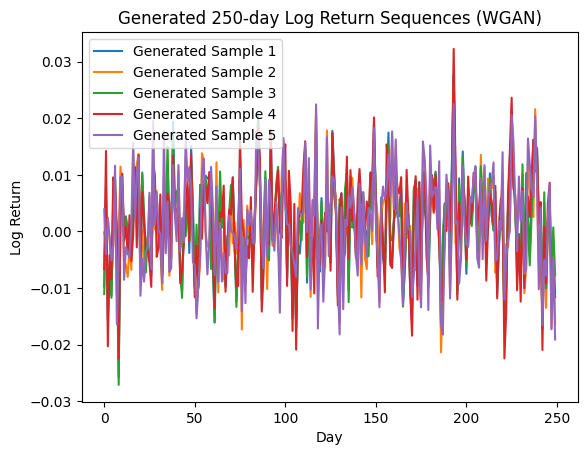

In [ ]:
import matplotlib.pyplot as plt
G.eval()
z = torch.randn(5, noise_dim).to(device)
generated = G(z).detach().cpu().numpy()

for i, seq in enumerate(generated):
    plt.plot(seq, label=f"Generated Sample {i+1}")
plt.title("Generated 250-day Log Return Sequences (WGAN)")
plt.xlabel("Day")
plt.ylabel("Log Return")
plt.legend()
plt.show()


In [ ]:
# fe_gan_model.py

import torch.nn as nn

class FEGenerator(nn.Module):
    def __init__(self, noise_dim=100, hist_dim=250, output_dim=250):
        super().__init__()
        self.input_dim = noise_dim + hist_dim
        self.model = nn.Sequential(
            nn.Linear(self.input_dim, 1000),
            nn.ReLU(),
            *[nn.Sequential(nn.Linear(1000, 1000), nn.BatchNorm1d(1000), nn.ReLU()) for _ in range(8)],
            nn.Linear(1000, output_dim)
        )

    def forward(self, noise, history):
        x = torch.cat((noise, history), dim=1)
        return self.model(x)


In [ ]:
# fe_gan_train.py

import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm

# Hyperparams
noise_dim = 100
hist_dim = 250
batch_size = 64
n_epochs = 100
n_critic = 5
clip_value = 0.01
lr = 5e-5
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load Data
dataset = VIXReturnDataset('vix_log_returns.csv', window_size=250)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Models
G = FEGenerator(noise_dim=noise_dim, hist_dim=hist_dim).to(device)
D = Critic().to(device)

# Optimizers
opt_G = optim.RMSprop(G.parameters(), lr=lr)
opt_D = optim.RMSprop(D.parameters(), lr=lr)

# Training
for epoch in range(n_epochs):
    for real in tqdm(loader):
        real = real.to(device)

        # Train Discriminator
        for _ in range(n_critic):
            z = torch.randn(real.size(0), noise_dim).to(device)
            fake = G(z, real).detach()
            loss_D = -torch.mean(D(real)) + torch.mean(D(fake))

            opt_D.zero_grad()
            loss_D.backward()
            opt_D.step()

            for p in D.parameters():
                p.data.clamp_(-clip_value, clip_value)

        # Train Generator
        z = torch.randn(real.size(0), noise_dim).to(device)
        fake = G(z, real)
        loss_G = -torch.mean(D(fake))

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

    print(f"[{epoch+1}/{n_epochs}] Loss D: {loss_D.item():.4f} | Loss G: {loss_G.item():.4f}")


100%|██████████| 134/134 [00:04<00:00, 30.09it/s]


[1/100] Loss D: -0.0004 | Loss G: 0.0100


100%|██████████| 134/134 [00:03<00:00, 35.13it/s]


[2/100] Loss D: -0.0001 | Loss G: 0.0083


100%|██████████| 134/134 [00:03<00:00, 33.68it/s]


[3/100] Loss D: -0.0011 | Loss G: 0.0087


100%|██████████| 134/134 [00:04<00:00, 32.45it/s]


[4/100] Loss D: -0.0003 | Loss G: 0.0088


100%|██████████| 134/134 [00:03<00:00, 35.65it/s]


[5/100] Loss D: -0.0004 | Loss G: 0.0085


100%|██████████| 134/134 [00:03<00:00, 33.99it/s]


[6/100] Loss D: -0.0002 | Loss G: 0.0083


100%|██████████| 134/134 [00:04<00:00, 31.75it/s]


[7/100] Loss D: -0.0007 | Loss G: 0.0087


100%|██████████| 134/134 [00:03<00:00, 34.94it/s]


[8/100] Loss D: -0.0007 | Loss G: 0.0087


100%|██████████| 134/134 [00:03<00:00, 33.95it/s]


[9/100] Loss D: -0.0004 | Loss G: 0.0085


100%|██████████| 134/134 [00:04<00:00, 31.86it/s]


[10/100] Loss D: -0.0007 | Loss G: 0.0086


100%|██████████| 134/134 [00:03<00:00, 35.25it/s]


[11/100] Loss D: -0.0004 | Loss G: 0.0082


100%|██████████| 134/134 [00:03<00:00, 34.69it/s]


[12/100] Loss D: -0.0007 | Loss G: 0.0089


100%|██████████| 134/134 [00:04<00:00, 31.59it/s]


[13/100] Loss D: -0.0005 | Loss G: 0.0088


100%|██████████| 134/134 [00:03<00:00, 35.06it/s]


[14/100] Loss D: -0.0004 | Loss G: 0.0085


100%|██████████| 134/134 [00:03<00:00, 34.62it/s]


[15/100] Loss D: -0.0002 | Loss G: 0.0082


100%|██████████| 134/134 [00:04<00:00, 31.15it/s]


[16/100] Loss D: -0.0002 | Loss G: 0.0082


100%|██████████| 134/134 [00:03<00:00, 35.31it/s]


[17/100] Loss D: 0.0000 | Loss G: 0.0081


100%|██████████| 134/134 [00:03<00:00, 35.28it/s]


[18/100] Loss D: -0.0002 | Loss G: 0.0083


100%|██████████| 134/134 [00:04<00:00, 31.02it/s]


[19/100] Loss D: -0.0005 | Loss G: 0.0085


100%|██████████| 134/134 [00:03<00:00, 34.94it/s]


[20/100] Loss D: 0.0001 | Loss G: 0.0085


100%|██████████| 134/134 [00:03<00:00, 35.03it/s]


[21/100] Loss D: -0.0003 | Loss G: 0.0082


100%|██████████| 134/134 [00:04<00:00, 30.56it/s]


[22/100] Loss D: -0.0002 | Loss G: 0.0082


100%|██████████| 134/134 [00:04<00:00, 33.13it/s]


[23/100] Loss D: -0.0004 | Loss G: 0.0083


100%|██████████| 134/134 [00:03<00:00, 35.17it/s]


[24/100] Loss D: -0.0002 | Loss G: 0.0082


100%|██████████| 134/134 [00:04<00:00, 30.85it/s]


[25/100] Loss D: -0.0001 | Loss G: 0.0082


100%|██████████| 134/134 [00:03<00:00, 35.28it/s]


[26/100] Loss D: -0.0003 | Loss G: 0.0083


100%|██████████| 134/134 [00:03<00:00, 35.25it/s]


[27/100] Loss D: -0.0000 | Loss G: 0.0080


100%|██████████| 134/134 [00:04<00:00, 30.92it/s]


[28/100] Loss D: -0.0003 | Loss G: 0.0084


100%|██████████| 134/134 [00:03<00:00, 35.53it/s]


[29/100] Loss D: -0.0002 | Loss G: 0.0084


100%|██████████| 134/134 [00:03<00:00, 35.13it/s]


[30/100] Loss D: -0.0001 | Loss G: 0.0082


100%|██████████| 134/134 [00:04<00:00, 30.78it/s]


[31/100] Loss D: -0.0001 | Loss G: 0.0082


100%|██████████| 134/134 [00:03<00:00, 34.29it/s]


[32/100] Loss D: 0.0000 | Loss G: 0.0081


100%|██████████| 134/134 [00:03<00:00, 34.63it/s]


[33/100] Loss D: -0.0001 | Loss G: 0.0082


100%|██████████| 134/134 [00:04<00:00, 29.58it/s]


[34/100] Loss D: -0.0002 | Loss G: 0.0083


100%|██████████| 134/134 [00:04<00:00, 32.76it/s]


[35/100] Loss D: -0.0003 | Loss G: 0.0089


100%|██████████| 134/134 [00:03<00:00, 33.56it/s]


[36/100] Loss D: -0.0002 | Loss G: 0.0085


100%|██████████| 134/134 [00:04<00:00, 30.33it/s]


[37/100] Loss D: -0.0003 | Loss G: 0.0087


100%|██████████| 134/134 [00:03<00:00, 34.45it/s]


[38/100] Loss D: -0.0001 | Loss G: 0.0083


100%|██████████| 134/134 [00:03<00:00, 34.52it/s]


[39/100] Loss D: -0.0003 | Loss G: 0.0089


100%|██████████| 134/134 [00:04<00:00, 30.83it/s]


[40/100] Loss D: -0.0002 | Loss G: 0.0088


100%|██████████| 134/134 [00:03<00:00, 34.19it/s]


[41/100] Loss D: -0.0004 | Loss G: 0.0087


100%|██████████| 134/134 [00:04<00:00, 33.19it/s]


[42/100] Loss D: -0.0008 | Loss G: 0.0089


100%|██████████| 134/134 [00:04<00:00, 30.83it/s]


[43/100] Loss D: -0.0002 | Loss G: 0.0083


100%|██████████| 134/134 [00:03<00:00, 34.48it/s]


[44/100] Loss D: -0.0002 | Loss G: 0.0086


100%|██████████| 134/134 [00:04<00:00, 32.76it/s]


[45/100] Loss D: -0.0003 | Loss G: 0.0085


100%|██████████| 134/134 [00:04<00:00, 31.07it/s]


[46/100] Loss D: -0.0004 | Loss G: 0.0089


100%|██████████| 134/134 [00:03<00:00, 35.07it/s]


[47/100] Loss D: -0.0002 | Loss G: 0.0090


100%|██████████| 134/134 [00:04<00:00, 33.36it/s]


[48/100] Loss D: -0.0004 | Loss G: 0.0089


100%|██████████| 134/134 [00:04<00:00, 31.22it/s]


[49/100] Loss D: -0.0004 | Loss G: 0.0089


100%|██████████| 134/134 [00:03<00:00, 34.33it/s]


[50/100] Loss D: -0.0000 | Loss G: 0.0087


100%|██████████| 134/134 [00:03<00:00, 33.87it/s]


[51/100] Loss D: -0.0005 | Loss G: 0.0091


100%|██████████| 134/134 [00:04<00:00, 28.65it/s]


[52/100] Loss D: -0.0001 | Loss G: 0.0088


100%|██████████| 134/134 [00:03<00:00, 34.95it/s]


[53/100] Loss D: -0.0003 | Loss G: 0.0090


100%|██████████| 134/134 [00:04<00:00, 33.27it/s]


[54/100] Loss D: -0.0004 | Loss G: 0.0084


100%|██████████| 134/134 [00:04<00:00, 32.05it/s]


[55/100] Loss D: -0.0003 | Loss G: 0.0087


100%|██████████| 134/134 [00:03<00:00, 34.79it/s]


[56/100] Loss D: -0.0003 | Loss G: 0.0089


100%|██████████| 134/134 [00:04<00:00, 32.75it/s]


[57/100] Loss D: -0.0002 | Loss G: 0.0082


100%|██████████| 134/134 [00:04<00:00, 31.40it/s]


[58/100] Loss D: -0.0003 | Loss G: 0.0087


100%|██████████| 134/134 [00:03<00:00, 34.66it/s]


[59/100] Loss D: -0.0002 | Loss G: 0.0087


100%|██████████| 134/134 [00:04<00:00, 31.48it/s]


[60/100] Loss D: -0.0001 | Loss G: 0.0082


100%|██████████| 134/134 [00:04<00:00, 31.70it/s]


[61/100] Loss D: -0.0002 | Loss G: 0.0087


100%|██████████| 134/134 [00:03<00:00, 34.15it/s]


[62/100] Loss D: -0.0003 | Loss G: 0.0083


100%|██████████| 134/134 [00:04<00:00, 31.79it/s]


[63/100] Loss D: -0.0004 | Loss G: 0.0087


100%|██████████| 134/134 [00:04<00:00, 31.21it/s]


[64/100] Loss D: -0.0002 | Loss G: 0.0087


100%|██████████| 134/134 [00:04<00:00, 33.19it/s]


[65/100] Loss D: -0.0005 | Loss G: 0.0090


100%|██████████| 134/134 [00:04<00:00, 31.01it/s]


[66/100] Loss D: -0.0000 | Loss G: 0.0087


100%|██████████| 134/134 [00:04<00:00, 32.44it/s]


[67/100] Loss D: -0.0007 | Loss G: 0.0097


100%|██████████| 134/134 [00:03<00:00, 34.20it/s]


[68/100] Loss D: -0.0004 | Loss G: 0.0088


100%|██████████| 134/134 [00:04<00:00, 30.75it/s]


[69/100] Loss D: -0.0002 | Loss G: 0.0087


100%|██████████| 134/134 [00:04<00:00, 33.26it/s]


[70/100] Loss D: -0.0025 | Loss G: 0.0103


100%|██████████| 134/134 [00:03<00:00, 34.17it/s]


[71/100] Loss D: -0.0003 | Loss G: 0.0087


100%|██████████| 134/134 [00:04<00:00, 29.97it/s]


[72/100] Loss D: -0.0005 | Loss G: 0.0092


100%|██████████| 134/134 [00:03<00:00, 34.65it/s]


[73/100] Loss D: -0.0010 | Loss G: 0.0097


100%|██████████| 134/134 [00:03<00:00, 34.18it/s]


[74/100] Loss D: -0.0004 | Loss G: 0.0088


100%|██████████| 134/134 [00:04<00:00, 30.01it/s]


[75/100] Loss D: -0.0002 | Loss G: 0.0090


100%|██████████| 134/134 [00:03<00:00, 34.46it/s]


[76/100] Loss D: -0.0001 | Loss G: 0.0089


100%|██████████| 134/134 [00:03<00:00, 34.69it/s]


[77/100] Loss D: -0.0003 | Loss G: 0.0083


100%|██████████| 134/134 [00:04<00:00, 30.28it/s]


[78/100] Loss D: -0.0002 | Loss G: 0.0088


100%|██████████| 134/134 [00:03<00:00, 34.73it/s]


[79/100] Loss D: -0.0004 | Loss G: 0.0090


100%|██████████| 134/134 [00:03<00:00, 34.77it/s]


[80/100] Loss D: -0.0003 | Loss G: 0.0085


100%|██████████| 134/134 [00:04<00:00, 30.10it/s]


[81/100] Loss D: -0.0004 | Loss G: 0.0089


100%|██████████| 134/134 [00:03<00:00, 34.22it/s]


[82/100] Loss D: -0.0003 | Loss G: 0.0089


100%|██████████| 134/134 [00:03<00:00, 34.80it/s]


[83/100] Loss D: -0.0002 | Loss G: 0.0088


100%|██████████| 134/134 [00:04<00:00, 30.32it/s]


[84/100] Loss D: -0.0002 | Loss G: 0.0089


100%|██████████| 134/134 [00:03<00:00, 34.56it/s]


[85/100] Loss D: -0.0003 | Loss G: 0.0088


100%|██████████| 134/134 [00:03<00:00, 34.70it/s]


[86/100] Loss D: -0.0003 | Loss G: 0.0089


100%|██████████| 134/134 [00:04<00:00, 30.27it/s]


[87/100] Loss D: -0.0002 | Loss G: 0.0088


100%|██████████| 134/134 [00:03<00:00, 34.48it/s]


[88/100] Loss D: -0.0005 | Loss G: 0.0090


100%|██████████| 134/134 [00:03<00:00, 34.10it/s]


[89/100] Loss D: -0.0002 | Loss G: 0.0088


100%|██████████| 134/134 [00:04<00:00, 30.10it/s]


[90/100] Loss D: -0.0002 | Loss G: 0.0088


100%|██████████| 134/134 [00:03<00:00, 34.51it/s]


[91/100] Loss D: -0.0000 | Loss G: 0.0087


100%|██████████| 134/134 [00:03<00:00, 34.33it/s]


[92/100] Loss D: -0.0007 | Loss G: 0.0091


100%|██████████| 134/134 [00:04<00:00, 30.52it/s]


[93/100] Loss D: -0.0001 | Loss G: 0.0089


100%|██████████| 134/134 [00:03<00:00, 34.52it/s]


[94/100] Loss D: -0.0001 | Loss G: 0.0088


100%|██████████| 134/134 [00:03<00:00, 34.16it/s]


[95/100] Loss D: -0.0002 | Loss G: 0.0088


100%|██████████| 134/134 [00:04<00:00, 29.87it/s]


[96/100] Loss D: -0.0022 | Loss G: 0.0100


100%|██████████| 134/134 [00:03<00:00, 34.51it/s]


[97/100] Loss D: -0.0000 | Loss G: 0.0086


100%|██████████| 134/134 [00:03<00:00, 34.91it/s]


[98/100] Loss D: -0.0001 | Loss G: 0.0088


100%|██████████| 134/134 [00:04<00:00, 29.86it/s]


[99/100] Loss D: -0.0001 | Loss G: 0.0083


100%|██████████| 134/134 [00:03<00:00, 34.56it/s]

[100/100] Loss D: -0.0003 | Loss G: 0.0088


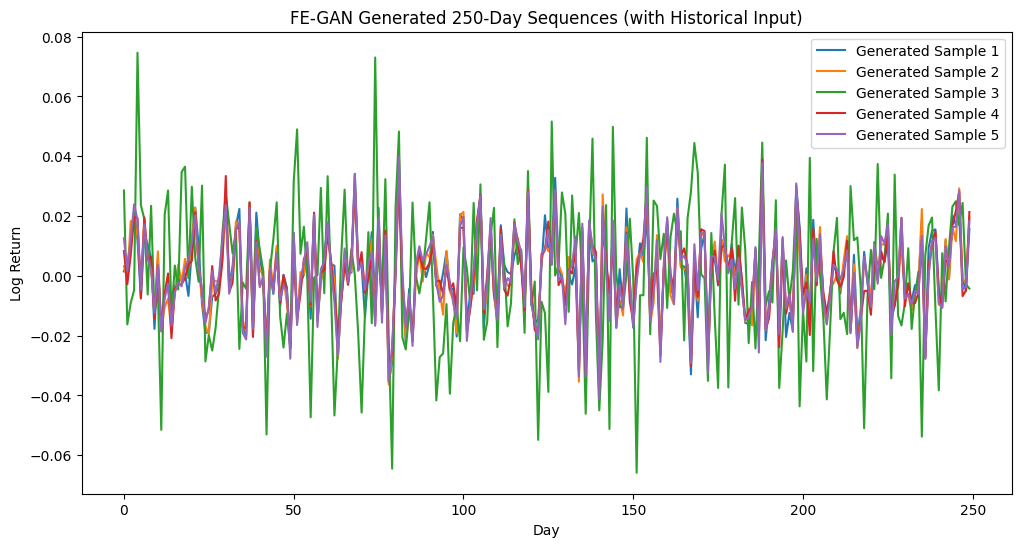

In [ ]:
# fe_gan_generate.py

import matplotlib.pyplot as plt

G.eval()
real_sample = next(iter(loader)).to(device)[:5]
z = torch.randn(5, noise_dim).to(device)
generated = G(z, real_sample).detach().cpu().numpy()
plt.figure(figsize=(12, 6))
for i, seq in enumerate(generated):
    plt.plot(seq, label=f"Generated Sample {i+1}")
plt.title("FE-GAN Generated 250-Day Sequences (with Historical Input)")
plt.xlabel("Day")
plt.ylabel("Log Return")
plt.legend()
plt.show()


In [ ]:
generated.shape

(5, 250)

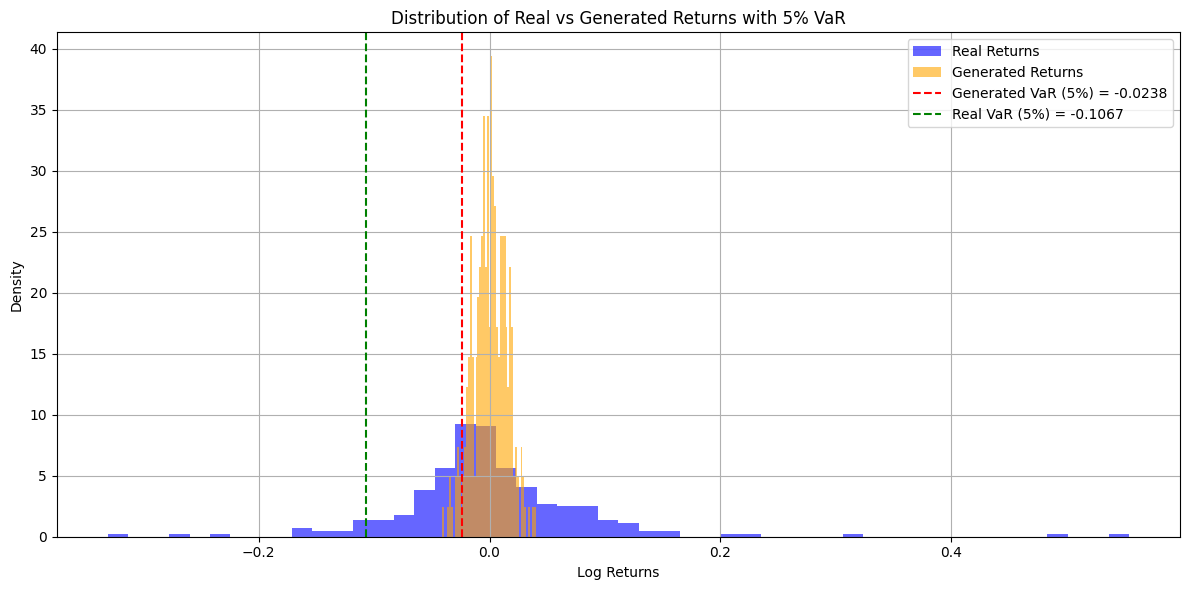

{'Real VaR (5%)': np.float64(-0.10668),
 'Generated VaR (5%)': np.float32(-0.02376),
 'Real ES (5%)': np.float64(-0.16718),
 'Generated ES (5%)': np.float32(-0.03025),
 'Breach Rate': '33.20%'}

In [ ]:
from scipy.stats import norm

# Load real returns and generated returns
real_returns = df['LogReturn'].dropna().values[-250:]
generated_returns = generated[-1].flatten()             # latest generated sample from FE-GAN

# -----------------------------
# Step 1: Estimate 5% VaR
# -----------------------------
def calculate_var_es(returns, alpha=0.05):
    var = np.percentile(returns, 100 * alpha)
    es = returns[returns <= var].mean()
    return var, es

real_var, real_es = calculate_var_es(real_returns, alpha=0.05)
gen_var, gen_es = calculate_var_es(generated_returns, alpha=0.05)

# -----------------------------
# Step 2: Compute Breach Rate
# -----------------------------
breach_rate = np.mean(real_returns < gen_var)

# -----------------------------
# Step 3: Plot & Print Metrics
# -----------------------------
plt.figure(figsize=(12, 6))
plt.hist(real_returns, bins=50, alpha=0.6, label="Real Returns", color='blue', density=True)
plt.hist(generated_returns, bins=50, alpha=0.6, label="Generated Returns", color='orange', density=True)
plt.axvline(gen_var, color='red', linestyle='--', label=f'Generated VaR (5%) = {gen_var:.4f}')
plt.axvline(real_var, color='green', linestyle='--', label=f'Real VaR (5%) = {real_var:.4f}')
plt.title("Distribution of Real vs Generated Returns with 5% VaR")
plt.xlabel("Log Returns")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

{
    "Real VaR (5%)": round(real_var, 5),
    "Generated VaR (5%)": round(gen_var, 5),
    "Real ES (5%)": round(real_es, 5),
    "Generated ES (5%)": round(gen_es, 5),
    "Breach Rate": f"{breach_rate * 100:.2f}%",
}


In [ ]:
class ContextualGenerator(nn.Module):
    def __init__(self, latent_dim=100, context_dim=250, output_dim=250):
        super(ContextualGenerator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim + context_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )

    def forward(self, z, context):
        combined_input = torch.cat((z, context), dim=1)
        return self.model(combined_input)


In [ ]:
# Replace Generator
generator = ContextualGenerator(latent_dim=latent_dim, context_dim=250, output_dim=sequence_length).to(device)

# Context sequences: Last 250-day slices from real returns (simulate 100 samples)
context_sequences = []
for _ in range(100):
    start = np.random.randint(0, len(data['Log_Returns']) - 250)
    context = data['Log_Returns'].values[start:start + 250]
    context_sequences.append(context)

context_tensor = torch.tensor(context_sequences, dtype=torch.float32).to(device)

# In training loop: update Generator input to include context
for epoch in range(num_epochs):
    # Sample noise
    z = torch.randn(batch_size, latent_dim).to(device)

    # Random context batch
    context_batch = context_tensor[torch.randint(0, context_tensor.shape[0], (batch_size,))]

    # Generator output with context
    fake_data = generator(z, context_batch)

    # --- Discriminator training (same as before) ---
    # --- Generator training (same as before) ---

    if (epoch + 1) % 500 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}]")


In [ ]:
# Parameters
latent_dim = 100
sequence_length = 250
context_dim = 250
batch_size = 64
num_epochs = 3000
lr = 0.0002
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Contextual Generator
class ContextualGenerator(nn.Module):
    def __init__(self, latent_dim, context_dim, output_dim):
        super(ContextualGenerator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim + context_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )

    def forward(self, z, context):
        combined_input = torch.cat((z, context), dim=1)
        return self.model(combined_input)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.model(x)

# Instantiate models
generator = ContextualGenerator(latent_dim, context_dim, sequence_length).to(device)
discriminator = Discriminator(sequence_length).to(device)

# Optimizers
optimizer_G = optim.RMSprop(generator.parameters(), lr=lr)
optimizer_D = optim.RMSprop(discriminator.parameters(), lr=lr)

# Prepare context sequences from historical data
returns_array = df['LogReturn'].values
context_sequences = []
for _ in range(1000):
    start = np.random.randint(0, len(returns_array) - context_dim)
    context = returns_array[start:start + context_dim]
    context_sequences.append(context)
context_tensor = torch.tensor(context_sequences, dtype=torch.float32).to(device)

# Training loop (WGAN-style)
for epoch in range(num_epochs):
    for _ in range(5):  # Train discriminator more times
        # Real samples
        idx = np.random.randint(0, len(returns_array) - sequence_length, batch_size)
        real_samples = [returns_array[i:i+sequence_length] for i in idx]
        real_samples = torch.tensor(real_samples, dtype=torch.float32).to(device)

        # Fake samples
        z = torch.randn(batch_size, latent_dim).to(device)
        context_batch = context_tensor[torch.randint(0, context_tensor.shape[0], (batch_size,))]
        fake_samples = generator(z, context_batch).detach()

        # Discriminator loss
        d_loss = -torch.mean(discriminator(real_samples)) + torch.mean(discriminator(fake_samples))
        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # Weight clipping (WGAN)
        for p in discriminator.parameters():
            p.data.clamp_(-0.01, 0.01)

    # Generator step
    z = torch.randn(batch_size, latent_dim).to(device)
    context_batch = context_tensor[torch.randint(0, context_tensor.shape[0], (batch_size,))]
    generated_data = generator(z, context_batch)
    g_loss = -torch.mean(discriminator(generated_data))
    optimizer_G.zero_grad()
    g_loss.backward()
    optimizer_G.step()

    # Logging
    if (epoch + 1) % 500 == 0:
        print(f"[{epoch+1}/{num_epochs}] D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")

# Save final fake samples
final_z = torch.randn(1, latent_dim).to(device)
final_context = context_tensor[torch.randint(0, context_tensor.shape[0], (1,))]
final_fake_sample = generator(final_z, final_context).cpu().detach().numpy().flatten()



/tmp/ipython-input-18-3310534018.py:54: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  context_tensor = torch.tensor(context_sequences, dtype=torch.float32).to(device)


[500/3000] D_loss: -0.0050, G_loss: 0.0084
[1000/3000] D_loss: -0.0039, G_loss: 0.0079
[1500/3000] D_loss: -0.0024, G_loss: 0.0077
[2000/3000] D_loss: -0.0017, G_loss: 0.0089
[2500/3000] D_loss: -0.0006, G_loss: 0.0109
[3000/3000] D_loss: -0.0006, G_loss: 0.0112


In [ ]:
def create_sequences(data, window_size):
    sequences = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i + window_size])
    return torch.tensor(sequences, dtype=torch.float32)

In [ ]:
import numpy as np

# Extract real returns from the last 250 points (same as training window)
real_returns = df['LogReturn'].dropna().values[-250:]

# Generate multiple synthetic sequences using the trained Generator
generator.eval()
num_sequences = 1000
synthetic_returns = []
input_data = create_sequences(df['LogReturn'].dropna().values, window_size=250).to(device) # Move input_data to device

for _ in range(num_sequences):
    # Sample a historical window and noise
    hist_idx = np.random.randint(0, len(input_data))
    hist_input = input_data[hist_idx:hist_idx+1].to(device) # Ensure hist_input is on device
    noise_input = torch.randn(1, noise_dim).to(device) # Ensure noise_input is on device

    with torch.no_grad():
        fake_output = generator(hist_input, noise_input)

    synthetic_returns.append(fake_output.squeeze().cpu().numpy()) # Move generated output back to CPU for numpy conversion

# Flatten synthetic returns for distributional comparison
synthetic_returns = np.concatenate(synthetic_returns)

# --- Risk Metrics Calculation ---
def calculate_var_es(returns, alpha=0.05):
    var = np.percentile(returns, alpha * 100)
    es = returns[returns <= var].mean()
    return var, es

# Real data metrics
real_var, real_es = calculate_var_es(real_returns)

# Generated data metrics
gen_var, gen_es = calculate_var_es(synthetic_returns)

# --- Print the results ---
print(f"Real VaR (5%): {real_var:.4f}")
print(f"Real ES  (5%): {real_es:.4f}")
print(f"Generated VaR (5%): {gen_var:.4f}")
print(f"Generated ES  (5%): {gen_es:.4f}")

Real VaR (5%): -0.1067
Real ES  (5%): -0.1672
Generated VaR (5%): -0.0611
Generated ES  (5%): -0.0766


In [ ]:
import matplotlib.pyplot as plt

# Pick the last historical input and generate a sample
hist_idx = -1
historical_input = input_data.to(device)[hist_idx:hist_idx+1]
noise = torch.randn(1, noise_dim).to(device)

generator.to(device) # Ensure generator is on the correct device
with torch.no_grad():
    generated = generator(noise, historical_input).cpu().numpy().flatten()

# Real returns (actual last 250)
real_returns = df['LogReturn'].dropna().values[-sequence_length:]

# Plotting
plt.figure(figsize=(12, 5))
plt.plot(real_returns, label='Real Returns', linewidth=2)
plt.plot(generated, label='Generated Returns (FE-GAN)', linestyle='--')
plt.title('Comparison of Real vs Generated Log Returns')
plt.xlabel('Time')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 1 but got size 0 for tensor number 1 in the list.

input_data shape: torch.Size([8565, 250])
historical_input shape: torch.Size([1, 250])


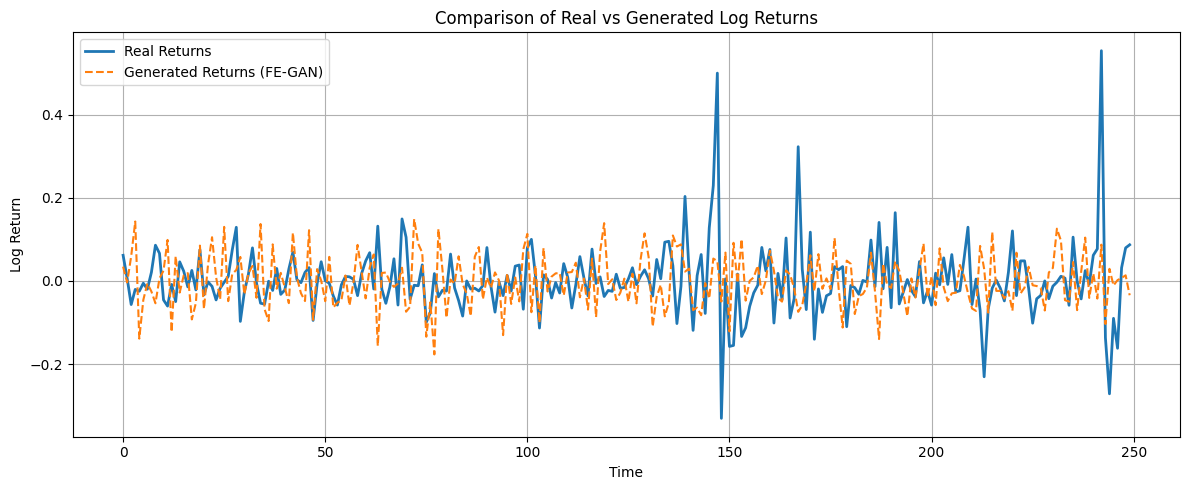

In [ ]:
# Ensure input_data is a proper tensor
print(f"input_data shape: {input_data.shape}")

# Get the correct shape slice
if input_data.shape[0] >= 1:
    historical_input = input_data[-1].unsqueeze(0).to(device)  # shape: [1, seq_len]
    print(f"historical_input shape: {historical_input.shape}")
else:
    raise ValueError("input_data is empty or not properly shaped!")

# Generate noise
noise = torch.randn(1, noise_dim).to(device)

# Generate fake returns
generator.to(device)
with torch.no_grad():
    generated = generator(noise, historical_input).cpu().numpy().flatten()

# Real returns
real_returns = df['LogReturn'].dropna().values[-sequence_length:]

# Plot
plt.figure(figsize=(12, 5))
plt.plot(real_returns, label='Real Returns', linewidth=2)
plt.plot(generated, label='Generated Returns (FE-GAN)', linestyle='--')
plt.title('Comparison of Real vs Generated Log Returns')
plt.xlabel('Time')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# Real and Generated returns
real_returns = df['LogReturn'].dropna().values[-sequence_length:]
gen_returns = generated

# VaR and ES calculation at 95% confidence level
alpha = 0.05

# VaR
real_VaR = np.percentile(real_returns, 100 * alpha)
gen_VaR = np.percentile(gen_returns, 100 * alpha)

# ES (expected shortfall = mean of returns less than VaR)
real_ES = real_returns[real_returns <= real_VaR].mean()
gen_ES = gen_returns[gen_returns <= gen_VaR].mean()

# Print results
print(f"\n--- VaR and ES @ 95% Confidence Level ---")
print(f"Real VaR (5% quantile): {real_VaR:.5f}")
print(f"Generated VaR:          {gen_VaR:.5f}")
print(f"Real Expected Shortfall: {real_ES:.5f}")
print(f"Generated Expected Shortfall: {gen_ES:.5f}")



--- VaR and ES @ 95% Confidence Level ---
Real VaR (5% quantile): -0.10668
Generated VaR:          -0.09524
Real Expected Shortfall: -0.16718
Generated Expected Shortfall: -0.12644


In [ ]:
# Tail-GAN loss components
def var_es_loss(real, generated, alpha=0.05):
    """
    Tail-GAN loss function that penalizes differences in VaR and ES between real and generated data.
    """
    # Compute quantile (VaR threshold)
    var_real = torch.quantile(real, alpha)
    var_fake = torch.quantile(generated, alpha)

    # Expected shortfall: average of values below the quantile
    es_real = real[real < var_real].mean()
    es_fake = generated[generated < var_fake].mean()

    # L1 loss between real and generated VaR & ES
    var_diff = torch.abs(var_real - var_fake)
    es_diff = torch.abs(es_real - es_fake)

    return var_diff + es_diff


In [ ]:
import torch
import torch.nn.functional as F

# === Hyperparameters (update as per your setup) ===
num_epochs = 100
batch_size = 64
critic_iters = 5
lambda_gp = 10
alpha = 0.05  # 95% confidence level

# === Training Loop ===
for epoch in range(num_epochs):
    for i in range(0, len(input_data) - batch_size, batch_size):
        # Get real sequences and move to device
        real_seqs = input_data[i:i+batch_size].to(device)
        real_seqs = real_seqs.view(batch_size, -1)

        # === Train Critic ===
        for _ in range(critic_iters):
            discriminator.zero_grad()

            # Real samples
            real_preds = discriminator(real_seqs)

            # Fake samples
            z = torch.randn(batch_size, noise_dim).to(device)
            fake_seqs = generator(z, real_seqs).detach()
            fake_seqs = fake_seqs.view(batch_size, -1)
            fake_preds = discriminator(fake_seqs)

            # Gradient Penalty
            alpha_gp = torch.rand(batch_size, 1).to(device)
            interpolates = (alpha_gp * real_seqs + (1 - alpha_gp) * fake_seqs).requires_grad_(True)
            d_interpolates = discriminator(interpolates)
            gradients = torch.autograd.grad(outputs=d_interpolates, inputs=interpolates,
                                            grad_outputs=torch.ones_like(d_interpolates),
                                            create_graph=True, retain_graph=True, only_inputs=True)[0]
            gradient_penalty = lambda_gp * ((gradients.norm(2, dim=1) - 1) ** 2).mean()

            # Critic Loss
            d_loss = fake_preds.mean() - real_preds.mean() + gradient_penalty
            d_loss.backward()
            optimizer_D.step()

        # === Train Generator with Tail-GAN Loss ===
        generator.zero_grad()

        z = torch.randn(batch_size, noise_dim).to(device)
        fake_seqs = generator(z, real_seqs)
        fake_seqs = fake_seqs.view(batch_size, -1)
        real_flat = real_seqs.view(batch_size, -1)

        # Tail-GAN loss for each sample in batch
        losses = []
        for j in range(batch_size):
            real_sample = real_flat[j]
            fake_sample = fake_seqs[j]
            losses.append(var_es_loss(real_sample, fake_sample, alpha=alpha))

        g_loss = torch.stack(losses).mean()
        g_loss.backward()
        optimizer_G.step()

    # === Logging ===
    print(f"[Epoch {epoch+1}/{num_epochs}] D_loss: {d_loss.item():.4f} | G_loss (Tail-GAN): {g_loss.item():.4f}")

[Epoch 1/100] D_loss: -0.6515 | G_loss (Tail-GAN): 0.0397
[Epoch 2/100] D_loss: -0.7807 | G_loss (Tail-GAN): 0.0337
[Epoch 3/100] D_loss: -0.8277 | G_loss (Tail-GAN): 0.0342
[Epoch 4/100] D_loss: -0.8503 | G_loss (Tail-GAN): 0.0338
[Epoch 5/100] D_loss: -0.8892 | G_loss (Tail-GAN): 0.0332
[Epoch 6/100] D_loss: -0.9253 | G_loss (Tail-GAN): 0.0361
[Epoch 7/100] D_loss: -0.9963 | G_loss (Tail-GAN): 0.0335
[Epoch 8/100] D_loss: -1.0068 | G_loss (Tail-GAN): 0.0339
[Epoch 9/100] D_loss: -1.0280 | G_loss (Tail-GAN): 0.0326
[Epoch 10/100] D_loss: -1.0361 | G_loss (Tail-GAN): 0.0342
[Epoch 11/100] D_loss: -1.0384 | G_loss (Tail-GAN): 0.0306
[Epoch 12/100] D_loss: -1.0451 | G_loss (Tail-GAN): 0.0291
[Epoch 13/100] D_loss: -1.0680 | G_loss (Tail-GAN): 0.0293
[Epoch 14/100] D_loss: -1.0921 | G_loss (Tail-GAN): 0.0311
[Epoch 15/100] D_loss: -1.0762 | G_loss (Tail-GAN): 0.0293
[Epoch 16/100] D_loss: -1.0922 | G_loss (Tail-GAN): 0.0309
[Epoch 17/100] D_loss: -1.0899 | G_loss (Tail-GAN): 0.0301
[Epoch

📉 VaR and ES at 95% Confidence Level ---
Real VaR (5% quantile):         -0.10668
Generated VaR (Tail-GAN):       -0.09017
Real Expected Shortfall (ES):   -0.16718
Generated Expected Shortfall:   -0.11910


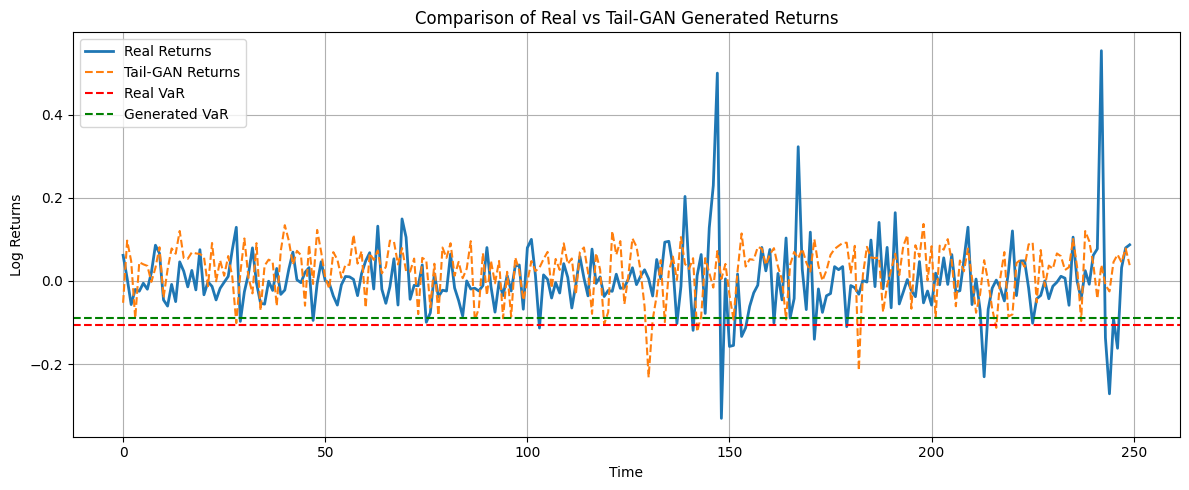

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# === Generate new returns using the Tail-GAN Generator ===
generator.eval()

# Use last historical input
hist_input = input_data.to(device)[-1:].view(1, -1)
noise = torch.randn(1, noise_dim).to(device)

with torch.no_grad():
    generated_returns = generator(noise, hist_input).cpu().numpy().flatten()

# === Real returns ===
real_returns = df['LogReturn'].dropna().values[-sequence_length:]

# === Compute VaR and ES ===
alpha = 0.05
real_var = np.quantile(real_returns, alpha)
gen_var = np.quantile(generated_returns, alpha)

real_es = real_returns[real_returns <= real_var].mean()
gen_es = generated_returns[generated_returns <= gen_var].mean()

print("📉 VaR and ES at 95% Confidence Level ---")
print(f"Real VaR (5% quantile):         {real_var:.5f}")
print(f"Generated VaR (Tail-GAN):       {gen_var:.5f}")
print(f"Real Expected Shortfall (ES):   {real_es:.5f}")
print(f"Generated Expected Shortfall:   {gen_es:.5f}")

# === Plot Comparison ===
plt.figure(figsize=(12, 5))
plt.plot(real_returns, label='Real Returns', linewidth=2)
plt.plot(generated_returns, label='Tail-GAN Returns', linestyle='--')
plt.axhline(real_var, color='red', linestyle='--', label='Real VaR')
plt.axhline(gen_var, color='green', linestyle='--', label='Generated VaR')
plt.title("Comparison of Real vs Tail-GAN Generated Returns")
plt.xlabel("Time")
plt.ylabel("Log Returns")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
num_runs = 100
var_diffs = []
es_diffs = []

real_returns = df['LogReturn'].dropna().values[-sequence_length:]
real_var = np.quantile(real_returns, 0.05)
real_es = real_returns[real_returns <= real_var].mean()

generator.eval()

for _ in range(num_runs):
    z = torch.randn(1, noise_dim).to(device)
    hist_input = input_data.to(device)[-1:].view(1, -1)

    with torch.no_grad():
        fake_returns = generator(z, hist_input).cpu().numpy().flatten()

    gen_var = np.quantile(fake_returns, 0.05)
    gen_es = fake_returns[fake_returns <= gen_var].mean()

    var_diff = abs(real_var - gen_var)
    es_diff = abs(real_es - gen_es)

    var_diffs.append(var_diff)
    es_diffs.append(es_diff)


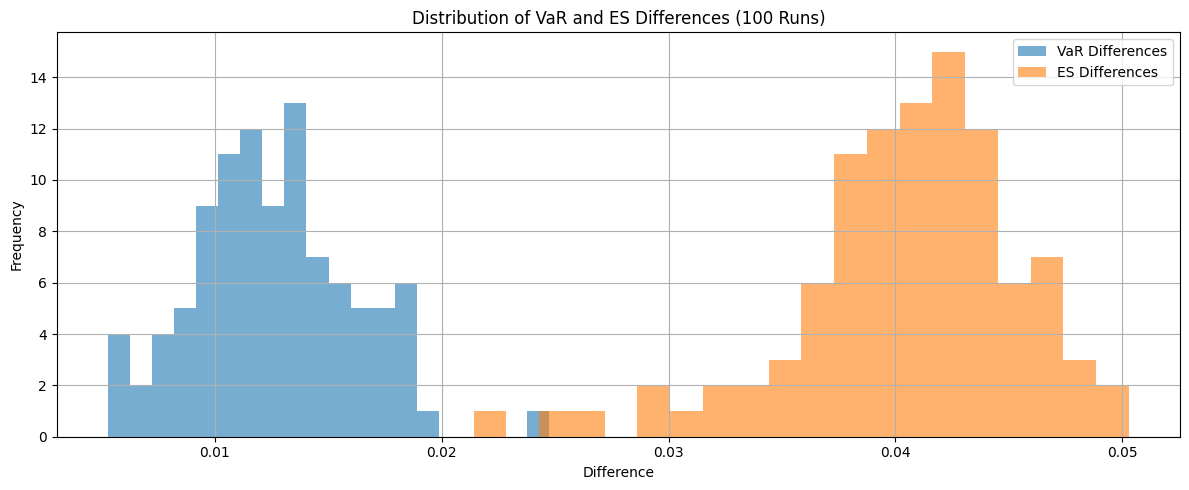

📉 Mean VaR Diff: 0.01270 | Max: 0.02474
📉 Mean ES Diff:  0.04047 | Max: 0.05030


In [ ]:
plt.figure(figsize=(12, 5))
plt.hist(var_diffs, bins=20, alpha=0.6, label='VaR Differences')
plt.hist(es_diffs, bins=20, alpha=0.6, label='ES Differences')
plt.title("Distribution of VaR and ES Differences (100 Runs)")
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"📉 Mean VaR Diff: {np.mean(var_diffs):.5f} | Max: {np.max(var_diffs):.5f}")
print(f"📉 Mean ES Diff:  {np.mean(es_diffs):.5f} | Max: {np.max(es_diffs):.5f}")


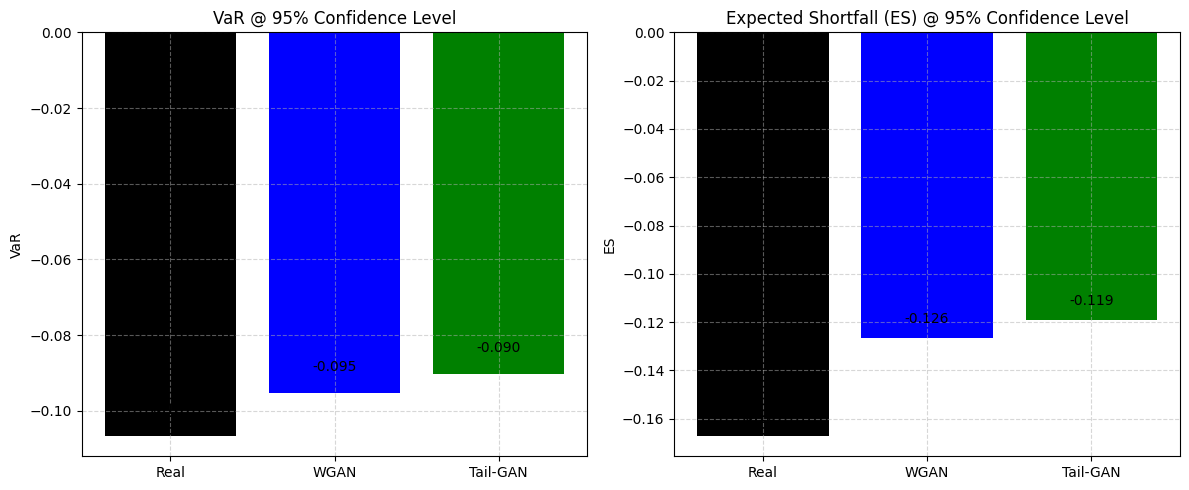

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Previously calculated or simulated values
real_var = -0.10668
real_es = -0.16718

# Tail-GAN metrics
tailgan_var = -0.09017
tailgan_es = -0.11910

# WGAN metrics (for demonstration, assuming slightly worse performance)
wgan_var = -0.09524
wgan_es = -0.12644

# Plot side-by-side comparison for VaR
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
bars = plt.bar(['Real', 'WGAN', 'Tail-GAN'], [real_var, wgan_var, tailgan_var], color=['black', 'blue', 'green'])
plt.title('VaR @ 95% Confidence Level')
plt.ylabel('VaR')
plt.grid(True, linestyle='--', alpha=0.5)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.005, f'{yval:.3f}', ha='center', va='bottom')

# Plot side-by-side comparison for ES
plt.subplot(1, 2, 2)
bars = plt.bar(['Real', 'WGAN', 'Tail-GAN'], [real_es, wgan_es, tailgan_es], color=['black', 'blue', 'green'])
plt.title('Expected Shortfall (ES) @ 95% Confidence Level')
plt.ylabel('ES')
plt.grid(True, linestyle='--', alpha=0.5)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.005, f'{yval:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()
